In [4]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader, Subset, random_split
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import random

# Set random seeds for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)


In [5]:
# 1. Define image transformations (with data augmentation)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(128, padding=4),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

# 2. Specify dataset directories
train_dir = "E:/Coding/projects/MajorProject/Alzheimer_Dataset/train/"
test_dir = "E:/Coding/projects/MajorProject/Alzheimer_Dataset/test/"

# 3. Load the dataset with transformations
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

print(f"Loaded {len(train_dataset)} training images.")
print(f"Loaded {len(test_dataset)} test images.")


Loaded 5121 training images.
Loaded 1279 test images.


In [6]:
# 4. Check the class distribution in the original dataset
class_counts = Counter([label for _, label in train_dataset.imgs])
print("Original class counts:", class_counts)

# 5. Set the target number of images per class
target_count = 1000

# 6. Create a balanced dataset
class_indices = {i: [] for i in range(len(train_dataset.classes))}

# Group image indices by their class labels
for idx, (_, label) in enumerate(train_dataset.imgs):
    class_indices[label].append(idx)

# List to store selected indices after balancing
balanced_indices = []

# Process each class for balancing
for class_label, indices in class_indices.items():
    if len(indices) >= target_count:
        # If more than 1000 images, randomly sample 1000
        selected_indices = random.sample(indices, target_count)
    else:
        # If fewer than 1000 images, oversample by repeating images
        selected_indices = indices + random.choices(indices, k=(target_count - len(indices)))
    
    balanced_indices.extend(selected_indices)

print(f"Total balanced images: {len(balanced_indices)}")


Original class counts: Counter({2: 2560, 3: 1792, 0: 717, 1: 52})
Total balanced images: 4000


In [7]:
# 7. Create a balanced subset of the dataset
balanced_train_dataset = Subset(train_dataset, balanced_indices)

# 8. Split the balanced dataset into training (80%) and validation (20%) sets
train_size = int(0.8 * len(balanced_train_dataset))
val_size = len(balanced_train_dataset) - train_size
train_subset, val_subset = random_split(balanced_train_dataset, [train_size, val_size])

print(f"Training subset size: {len(train_subset)}")
print(f"Validation subset size: {len(val_subset)}")


Training subset size: 3200
Validation subset size: 800


In [8]:
# 9. Create DataLoader for training, validation, and test sets
batch_size = 16

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 10. Check the new class distribution in the balanced dataset
balanced_class_counts = Counter([train_dataset.imgs[i][1] for i in balanced_indices])
print("Balanced class counts:", balanced_class_counts)


Balanced class counts: Counter({0: 1000, 1: 1000, 2: 1000, 3: 1000})


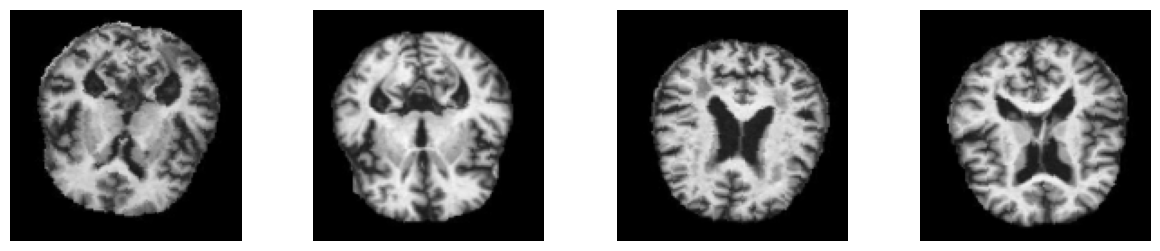

In [9]:
# 11. Visualize a batch of images from the training dataset
images, labels = next(iter(train_loader))
num_images = 4
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
class_names = train_dataset.classes

for i in range(num_images):
    img = images[i].numpy().transpose(1, 2, 0)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_xlabel(f'Class: {class_names[labels[i].item()]}')

plt.show()


In [10]:
# 12. Define ResNet50 or ResNet101 Model
class ResNetModel(nn.Module):
    def __init__(self, model_type='resnet50', num_classes=4):
        super(ResNetModel, self).__init__()
        if model_type == 'resnet50':
            self.resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)  # ResNet50
        else:
            self.resnet = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V1)  # ResNet101
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)  # Adjust final layer for 4 classes

    def forward(self, x):
        return self.resnet(x)

# Initialize the ResNet model (choose 'resnet50' or 'resnet101')
resnet_model = ResNetModel(model_type='resnet50', num_classes=4)  # Use 'resnet101' for ResNet101


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\bhart/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:56<00:00, 1.82MB/s]


In [11]:
# 13. Initialize Loss Function, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)

# 14. Use Learning Rate Scheduler to Adjust LR
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# 15. Move Model to Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model.to(device)


ResNetModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

In [12]:
# 16. Define a Function to Train and Validate Models
def train_validate(model, criterion, optimizer, train_loader, val_loader, device, scheduler, num_epochs=10):
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item() * images.size(0)
        
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        # Validation Phase
        model.eval()
        running_val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                running_val_loss += loss.item() * images.size(0)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        epoch_val_accuracy = correct / total
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)
        
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}")
        
        # Early Stopping Check
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_resnet_model.pth')
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break
        
        # Step the scheduler
        scheduler.step()
    
    return train_losses, val_losses, val_accuracies


In [13]:
# 17. Train and Validate ResNet50/101
print("Training ResNet Model...")
train_losses, val_losses, val_accuracies = train_validate(
    model=resnet_model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    scheduler=scheduler,
    num_epochs=10
)


Training ResNet Model...
Epoch 1/10, Train Loss: 0.9923, Val Loss: 1.0582, Val Accuracy: 0.5337
Epoch 2/10, Train Loss: 0.8010, Val Loss: 0.7786, Val Accuracy: 0.6238
Epoch 3/10, Train Loss: 0.7631, Val Loss: 0.7582, Val Accuracy: 0.6112
Epoch 4/10, Train Loss: 0.7261, Val Loss: 0.7000, Val Accuracy: 0.6412
Epoch 5/10, Train Loss: 0.6995, Val Loss: 2.8059, Val Accuracy: 0.3387
Epoch 6/10, Train Loss: 0.6254, Val Loss: 0.6202, Val Accuracy: 0.7113
Epoch 7/10, Train Loss: 0.5818, Val Loss: 0.5824, Val Accuracy: 0.7412
Epoch 8/10, Train Loss: 0.5694, Val Loss: 0.5601, Val Accuracy: 0.7375
Epoch 9/10, Train Loss: 0.5408, Val Loss: 0.5458, Val Accuracy: 0.7438
Epoch 10/10, Train Loss: 0.5315, Val Loss: 0.5496, Val Accuracy: 0.7312


<function matplotlib.pyplot.show(close=None, block=None)>

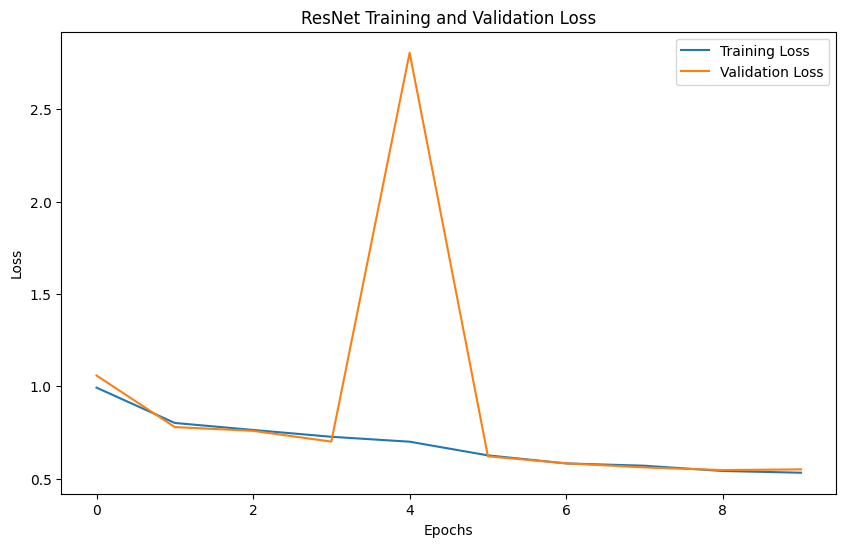

In [14]:
# 18. Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('ResNet Training and Validation Loss')
plt.legend()
plt.show
